# DNNにおけるbatch-normalizationの導入

【内容】  
- 5層のDNNでMNIST(数字画像)データの分類器を実装する
- 活性化関数をreluにする
- 各層の重みの初期値に正規化した値を入れる
- early-stoppingを実装する
- 学習率の設定をAdamにする
- ミニバッチ正規化(batch-normalization)を実装する

【目標】  
- ミニバッチ正規化を実装すると、学習率を大きくしても学習がうまくいくことを確認する  
（学習率をこれまで0.001から0.01にしている）

## ライブラリのインポート

In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn import datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

#tensorflowの互換性WARNING文の回避
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.FATAL)

np.random.seed(123)


Using TensorFlow backend.


## データの生成

In [2]:
# 研修用データロード
from mldata import mldata
X,Y,y,X_train,X_test,Y_train,Y_test, X_validation, Y_train, Y_validation = mldata.mldata2()

In [3]:
# # データロード
# # 使用するときは「ctrl+/」でコメントを外す
# mnist = datasets.fetch_openml('MNIST_784', version=1, return_X_y=False)

# n = len(mnist.data)
# N = 30000  # MNISTの一部を使う
# N_train = 20000
# N_validation = 4000
# indices = np.random.permutation(range(n))[:N]  # ランダムにN枚を選択

# X = mnist.data[indices]
# X = X / 255.0
# X = X - X.mean(axis=1).reshape(len(X), 1)
# y = mnist.target[indices]
# Y = np.eye(10)[y.astype(int)]

# X_train, X_test, Y_train, Y_test = \
#     train_test_split(X, Y, train_size=N_train)
# X_train, X_validation, Y_train, Y_validation = \
#     train_test_split(X_train, Y_train, test_size=N_validation)


## モデル設定

In [3]:
n_in = len(X[0])  # 784
n_hiddens = [200, 200, 200]
n_out = len(Y[0])  # 10
activation = 'relu'


def weight_variable(shape, name=None):
    return np.sqrt(1.0 / shape[0]) * np.random.normal(size=shape)


early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

model = Sequential()
for i, input_dim in enumerate(([n_in] + n_hiddens)[:-1]):
    model.add(Dense(n_hiddens[i], input_dim=input_dim,
                    kernel_initializer=weight_variable))
    model.add(BatchNormalization())
    model.add(Activation(activation))

model.add(Dense(n_out, kernel_initializer=weight_variable))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.01, beta_1=0.9, beta_2=0.999),
              metrics=['accuracy'])


In [4]:
# モデルのサマリを確認する
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               157000    
_________________________________________________________________
batch_normalization_1 (Batch (None, 200)               800       
_________________________________________________________________
activation_1 (Activation)    (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
batch_normalization_2 (Batch (None, 200)               800       
_________________________________________________________________
activation_2 (Activation)    (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 200)               40200     
__________

## モデル学習

In [5]:
epochs = 200
batch_size = 200

hist = model.fit(X_train, Y_train, epochs=epochs,
                 batch_size=batch_size,
                 validation_data=(X_validation, Y_validation),
                 callbacks=[early_stopping])


Train on 16000 samples, validate on 4000 samples
Epoch 1/200
16000/16000 [==============================] - 3s 206us/step - loss: 0.3309 - acc: 0.8959 - val_loss: 0.3038 - val_acc: 0.9135
Epoch 2/200
16000/16000 [==============================] - 1s 82us/step - loss: 0.1209 - acc: 0.9623 - val_loss: 0.3033 - val_acc: 0.9220
Epoch 3/200
16000/16000 [==============================] - 1s 89us/step - loss: 0.0945 - acc: 0.9702 - val_loss: 0.2480 - val_acc: 0.9345
Epoch 4/200
16000/16000 [==============================] - 1s 86us/step - loss: 0.0714 - acc: 0.9751 - val_loss: 0.2267 - val_acc: 0.9457
Epoch 5/200
16000/16000 [==============================] - 1s 86us/step - loss: 0.0507 - acc: 0.9839 - val_loss: 0.1960 - val_acc: 0.9522
Epoch 6/200
16000/16000 [==============================] - 1s 87us/step - loss: 0.0497 - acc: 0.9831 - val_loss: 0.2721 - val_acc: 0.9407
Epoch 7/200
16000/16000 [==============================] - 1s 84us/step - loss: 0.0524 - acc: 0.9836 - val_loss: 0.1837 - 

## 学習の進み具合を可視化

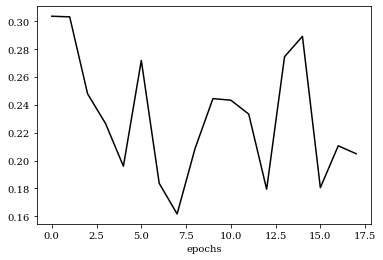

In [6]:
val_acc = hist.history['val_acc']
val_loss = hist.history['val_loss']

plt.rc('font', family='serif')
fig = plt.figure()
plt.plot(range(len(val_loss)), val_loss, label='loss', color='black')
plt.xlabel('epochs')
plt.show()


## 予測精度の評価

In [7]:
loss_and_metrics = model.evaluate(X_test, Y_test)
print(loss_and_metrics)

10000/10000 [==============================] - 1s 74us/step
[0.21213375595693068, 0.9594]
